Starting code for a MLP classifier for cardiac arrest for tabular data - Josh

In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



In [108]:
df = pd.read_csv("1000_nonca_574_ca.csv")
# df = pd.read_csv("added_feature_1000_nca_574_ca.csv")

In [109]:
df.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,cardiac,ADMITTIME,DISCHTIME,DOB,age
0,9633,79229,145474,67.0,21.0,96.0,NaN,NaN,M,0,2153/2/11 22:20,2153/2/14 18:00,2074/6/3 0:00,78
1,498,32511,102385,70.0,20.0,96.0,NaN,NaN,M,0,2147/9/22 6:12,2147/10/2 16:30,2060/10/23 0:00,86
2,11180,51767,152759,83.0,15.5,99.0,NaN,NaN,M,0,2191/6/16 11:45,2191/6/21 14:30,2132/7/18 0:00,58
3,8170,46755,138568,78.0,15.0,96.0,NaN,NaN,F,0,2183/3/8 10:24,2183/3/13 15:13,2122/10/27 0:00,60
4,13220,85417,162413,64.0,20.0,96.0,NaN,NaN,M,0,2183/9/8 0:19,2183/10/3 16:50,2131/11/1 0:00,51


In [110]:
df.drop(['ADMITTIME', 'DISCHTIME', 'DOB'], axis=1, inplace=True)
df.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,cardiac,age
0,9633,79229,145474,67.0,21.0,96.0,NaN,NaN,M,0,78
1,498,32511,102385,70.0,20.0,96.0,NaN,NaN,M,0,86
2,11180,51767,152759,83.0,15.5,99.0,NaN,NaN,M,0,58
3,8170,46755,138568,78.0,15.0,96.0,NaN,NaN,F,0,60
4,13220,85417,162413,64.0,20.0,96.0,NaN,NaN,M,0,51


In [111]:
# df = df[['SUBJECT_ID', 'HADM_ID', '220045', '220210', '220277', '224167', '227243','223770','223769','226253','220046','220047', 'gender','age','cardiac']]
df = df[['SUBJECT_ID', 'HADM_ID', '220045', '220210', '220277', '224167', '227243', 'gender','age','cardiac']]
df.head()

,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,age,cardiac
0,79229,145474,67.0,21.0,96.0,NaN,NaN,M,78,0
1,32511,102385,70.0,20.0,96.0,NaN,NaN,M,86,0
2,51767,152759,83.0,15.5,99.0,NaN,NaN,M,58,0
3,46755,138568,78.0,15.0,96.0,NaN,NaN,F,60,0
4,85417,162413,64.0,20.0,96.0,NaN,NaN,M,51,0


In [112]:
# pd.get_dummies(df['gender'])
cleanup_nums = {"gender":     {"F": 0, "M": 1}}
df.replace(cleanup_nums, inplace=True)
df.head()

,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,age,cardiac
0,79229,145474,67.0,21.0,96.0,NaN,NaN,1,78,0
1,32511,102385,70.0,20.0,96.0,NaN,NaN,1,86,0
2,51767,152759,83.0,15.5,99.0,NaN,NaN,1,58,0
3,46755,138568,78.0,15.0,96.0,NaN,NaN,0,60,0
4,85417,162413,64.0,20.0,96.0,NaN,NaN,1,51,0


In [113]:
df.drop(['SUBJECT_ID','HADM_ID','224167','227243'], axis=1, inplace=True)
df.head(2)

,220045,220210,220277,gender,age,cardiac
0,67.0,21.0,96.0,1,78,0
1,70.0,20.0,96.0,1,86,0


In [114]:
df=df.fillna(df.mean())


In [115]:
# TESTINGTESTINGTESTINGTESTINGTESTINGTESTINGTESTINGTESTING
# df.drop(['223770','223769','226253','220046','220047'], axis=1, inplace=True)
# df.head(2)

Look for a potential class imbalance here

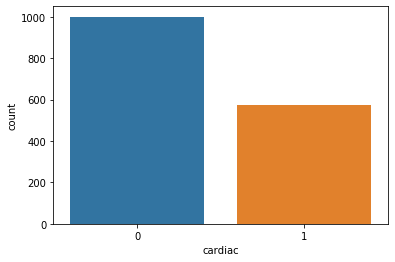

In [116]:
sns.countplot(x = 'cardiac', data=df)

In [117]:
# Class count
count_class_0, count_class_1 = df.cardiac.value_counts()
# Divide by class
df_class_0 = df[df['cardiac'] == 0]
df_class_1 = df[df['cardiac'] == 1]

Random under-sampling:
1    574
0    574
Name: cardiac, dtype: int64


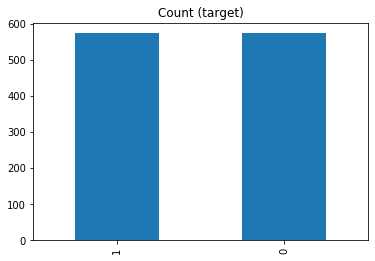

In [118]:
# Random under-sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.cardiac.value_counts())

df_test_under.cardiac.value_counts().plot(kind='bar', title='Count (target)');

In [119]:
df_test_under.head()

,220045,220210,220277,gender,age,cardiac
727,76.0,15.5,99.0,0,28,0
211,75.5,15.0,98.0,0,71,0
674,77.5,22.0,97.0,0,79,0
927,97.5,25.5,99.0,0,81,0
894,87.0,23.0,95.0,0,77,0


In [120]:
df.head()

,220045,220210,220277,gender,age,cardiac
0,67.0,21.0,96.0,1,78,0
1,70.0,20.0,96.0,1,86,0
2,83.0,15.5,99.0,1,58,0
3,78.0,15.0,96.0,0,60,0
4,64.0,20.0,96.0,1,51,0


In [121]:
df_test_under.to_csv('balanced_dataset.csv')

In [122]:
df_test_under=df_test_under.sort_index()

In [123]:
df=df_test_under

Encode Output Class (remaps the labels to start from 0) (not sure if needed)

In [124]:
# df['Cardiac_arrest'] = df['Cardiac_arrest'].astype('category')
# encode_map = {
#     'Abnormal': 1,
#     'Normal': 0
# }

# df['Cardiac_arrest'].replace(encode_map, inplace=True)

Create Input and Output Data

In [125]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [126]:
X.head(2)

,220045,220210,220277,gender,age
0,67.0,21.0,96.0,1,78
1,70.0,20.0,96.0,1,86


In [127]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1569    1
1570    1
1571    1
1572    1
1573    1
Name: cardiac, Length: 1148, dtype: int64

In [128]:
X=X.fillna(X.mean())
y=y.fillna(y.mean())

In [129]:
X

,220045,220210,220277,gender,age
0,67.0,21.0,96.0,1,78
1,70.0,20.0,96.0,1,86
2,83.0,15.5,99.0,1,58
3,78.0,15.0,96.0,0,60
4,64.0,20.0,96.0,1,51
...,...,...,...,...,...
1569,82.0,21.0,98.0,0,46
1570,65.5,17.0,94.0,1,86
1571,76.0,21.0,98.0,1,69
1572,65.0,18.0,97.0,0,59


In [130]:
# from sklearn import preprocessing

# x = X.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# X2 = pd.DataFrame(x_scaled)

In [131]:
# # DOING PCA
# import pandas as pd
# import numpy as np
# from sklearn.decomposition import PCA

# # df134124 = pd.DataFrame(data=np.random.normal(0, 1, (20, 10)))

# num_components=5

# pca = PCA(n_components=num_components)
# pca.fit(X)
# pca.components_ 
# X2=pd.DataFrame(pca.transform(X), columns=['PCA%i' % i for i in range(num_components)], index=df.index)


In [132]:
# print(pca.explained_variance_)


In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

In [134]:
X_train.head(5)

,220045,220210,220277,gender,age
495,75.0,16.0,98.0,1,34
1503,72.0,24.0,100.0,1,87
526,94.0,18.0,97.0,1,41
1218,103.0,17.0,98.0,1,77
1095,65.0,19.0,95.5,1,51


In [135]:
y_train.head(5)

495     0
1503    1
526     0
1218    1
1095    1
Name: cardiac, dtype: int64

In [136]:
X_train.shape

(769, 5)

In [137]:
X_test.shape

(379, 5)

In [138]:
y_test.shape

(379,)

In [139]:
y_train.shape

(769,)

Standardize Input Values

In [140]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

We do not need to perform Cross-Validation with a RF model, as the model performs and calculates its own CV metric known as OOB score. The confusion matrix printed by the model is calculated based on these OOB scores.

In [154]:
from sklearn.ensemble import RandomForestClassifier 
# creating a RF classifier 
clf = RandomForestClassifier(max_depth=5, n_estimators = 100, random_state=0)   
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
clf.fit(X_train, y_train) 
  
# performing predictions on the test dataset 
y_pred = clf.predict(X_test) 
  
# metrics are used to find accuracy or error 
from sklearn import metrics   
print() 
  
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred)) 
print("F1 OF THE MODEL: ", metrics.f1_score(y_test, y_pred)) 
print("Roc Auc OF THE MODEL: ", metrics.roc_auc_score(y_test, y_pred)) 



ACCURACY OF THE MODEL:  0.6226912928759895
F1 OF THE MODEL:  0.6323907455012854
Roc Auc OF THE MODEL:  0.6239827201783723


Model HyperParameters

In [160]:
# Calculate the confusion matrix
cf=confusion_matrix(y_test, y_pred)
cf

array([[113,  82],
       [ 61, 123]])

In [161]:
tn = cf[0][0]
fp = cf[0][1]
fn = cf[1][0]
tp = cf[1][1]
sensitivity= tp/(tp+fn)
specificity = tn /(tn+fp)
print('sensitivity: ',sensitivity)
print('specificity: ',specificity)

sensitivity:  0.6684782608695652
specificity:  0.5794871794871795


In [162]:
# Print classification report with precision, recall, and F1 score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.58      0.61       195
           1       0.60      0.67      0.63       184

    accuracy                           0.62       379
   macro avg       0.62      0.62      0.62       379
weighted avg       0.63      0.62      0.62       379



In [165]:
metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.6516164994425864